<a href="https://colab.research.google.com/github/Yuji-ONUKI/GCI2020_Winter/blob/main/June25_1515_home_credit_default_risk_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="border-radius:10px;
    border:#410159 solid;
    background-color:#fef1ff;
    font-size:110%;
    letter-spacing:0.5px;
    text-align: center">
<center><h1 style="padding: 25px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Home credit default risk</h1></center>
<center><h3 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">With LightGBM classifier</h3></center>
<center><h4 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">(Second challenge)</h4></center>
</div>

In [ ]:
import numpy as np 
import pandas as pd 

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [ ]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
%cd "/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2


# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# ----------------------------------------------------
import sklearn
import scipy
import statsmodels.api as sm 
from scipy.stats import shapiro

# ----------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# ----------------------------------------------------
from lightgbm import LGBMClassifier

# ----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Define functions

In [ ]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 3 * iqr_col)) |(df[col] > (q3_col + 3 * iqr_col)))]

# ----------------------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 3 * iqr_col))]
    return lower

# ----------------------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 3 * iqr_col))]
    return upper

# ----------------------------------------------------------
def preprocess(df, col):
    print("*********************** {} ***********************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.subplot(2,1,2)
    df[col].plot(kind='density', subplots=True, sharex=False)
    plt.show()

# ----------------------------------------------------------
def preprocess_cat(df, col):
    print("******************** {} ********************\n".format(col))
    df[col].value_counts().plot(kind='bar')
    plt.xticks(rotation='vertical')
    plt.show()
    
# ----------------------------------------------------------
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 3 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)

# ----------------------------------------------------------
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 3 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)

# ----------------------------------------------------------
def replace_mode(df, col):
    df[col] = df[col].fillna(df[col].mode()[0])
    print("NaN in {} raplaced with {}".format(col, df[col].mode()[0]))

# ----------------------------------------------------------
def replace_mean(df, col):
    df[col] = df[col].fillna(df[col].mean())
    print("NaN in {} raplaced with {}".format(col, df[col].mean()))
    

def replace_median(df, col):
    df[col] = df[col].fillna(df[col].median())
    print("NaN in {} raplaced with {}".format(col, df[col].median()))
    

# ----------------------------------------------------------
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())
    
# ----------------------------------------------------------
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    return (clf.best_score_)

# Data Understanding

In [ ]:
# IPython magic to ensure Python compatibility.
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/train.csv")
test = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/test.csv")


# 欠損値等に特定値を充てているものの処理

In [ ]:
columns = train.keys()


In [ ]:
train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [ ]:
cols = train.dtypes[train.dtypes=='int64'].keys()
cols = cols[2:]

In [ ]:
for col in cols:
    train[col]=train[col].astype(float)
    test[col]=test[col].astype(float)

In [ ]:
for col in list(train.dtypes[train.dtypes=='float64'].keys()):
  if train.loc[train[col].isna(),'SK_ID_CURR'].count()>0:
     print(col, train.loc[train[col].isna(),'SK_ID_CURR'].count())

AMT_ANNUITY 6
AMT_GOODS_PRICE 163
OWN_CAR_AGE 112992
CNT_FAM_MEMBERS 2
EXT_SOURCE_1 118928
EXT_SOURCE_2 369
EXT_SOURCE_3 54586
OBS_30_CNT_SOCIAL_CIRCLE 560
DEF_30_CNT_SOCIAL_CIRCLE 560
OBS_60_CNT_SOCIAL_CIRCLE 560
DEF_60_CNT_SOCIAL_CIRCLE 560
DAYS_LAST_PHONE_CHANGE 1
AMT_REQ_CREDIT_BUREAU_HOUR 23116
AMT_REQ_CREDIT_BUREAU_MON 23116
AMT_REQ_CREDIT_BUREAU_QRT 23116
AMT_REQ_CREDIT_BUREAU_YEAR 23116


DAYS_LAST_PHONE_CHANGEはtrainのみ欠測値1

In [ ]:
for col in list(test.dtypes[test.dtypes=='float64'].keys()):
  if test.loc[test[col].isna(),'SK_ID_CURR'].count()>0:
     print(col, test.loc[test[col].isna(),'SK_ID_CURR'].count())

AMT_ANNUITY 3
AMT_GOODS_PRICE 53
OWN_CAR_AGE 40909
EXT_SOURCE_1 42912
EXT_SOURCE_2 130
EXT_SOURCE_3 19690
OBS_30_CNT_SOCIAL_CIRCLE 181
DEF_30_CNT_SOCIAL_CIRCLE 181
OBS_60_CNT_SOCIAL_CIRCLE 181
DEF_60_CNT_SOCIAL_CIRCLE 181
AMT_REQ_CREDIT_BUREAU_HOUR 8513
AMT_REQ_CREDIT_BUREAU_MON 8513
AMT_REQ_CREDIT_BUREAU_QRT 8513
AMT_REQ_CREDIT_BUREAU_YEAR 8513


In [ ]:
for col in list(train.dtypes[train.dtypes!=object].keys()):
  if train[col].max()*train[col].min() < 0:
     print(col)

DAYS_EMPLOYED


In [ ]:
train['FLAG_NOT_EMPLOYED']=0
train.loc[train['DAYS_EMPLOYED']==365243,'FLAG_NOT_EMPLOYED']=1
train.loc[train['DAYS_EMPLOYED']==365243,'DAYS_EMPLOYED']=np.NAN
test['FLAG_NOT_EMPLOYED']=0
test.loc[test['DAYS_EMPLOYED']==365243,'FLAG_NOT_EMPLOYED']=1
test.loc[test['DAYS_EMPLOYED']==365243,'DAYS_EMPLOYED']=np.NAN

In [ ]:
for col in list(train.dtypes[train.dtypes!=object].keys()):
  if train[col].max()<= 0:
     print(col)

DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
DAYS_LAST_PHONE_CHANGE


In [ ]:
train['DAYS_BIRTH']=-1 * train['DAYS_BIRTH']
test['DAYS_BIRTH']=-1 * test['DAYS_BIRTH']

train['DAYS_EMPLOYED']=-1 * train['DAYS_EMPLOYED']
test['DAYS_EMPLOYED']=-1 * test['DAYS_EMPLOYED']

train['DAYS_REGISTRATION']=-1 * train['DAYS_REGISTRATION']
test['DAYS_REGISTRATION']=-1 * test['DAYS_REGISTRATION']

train['DAYS_ID_PUBLISH']=-1 * train['DAYS_ID_PUBLISH']
test['DAYS_ID_PUBLISH']=-1 * test['DAYS_ID_PUBLISH']

train['DAYS_LAST_PHONE_CHANGE']=-1 * train['DAYS_LAST_PHONE_CHANGE']
test['DAYS_LAST_PHONE_CHANGE']=-1 * test['DAYS_LAST_PHONE_CHANGE']

In [ ]:
train['YEARS_BIRTH']=round(train['DAYS_BIRTH']/365)
test['YEARS_BIRTH']=round(test['DAYS_BIRTH']/365)

train['YEARS_ID_PUBLISH']=round(train['DAYS_ID_PUBLISH']/365)
test['YEARS_ID_PUBLISH']=round(test['DAYS_ID_PUBLISH']/365)

train['YEARS_REGISTRATION']=round(train['DAYS_REGISTRATION']/365)
test['YEARS_REGISTRATION']=round(test['DAYS_REGISTRATION']/365)

train['YEARS_LAST_PHONE_CHANGE']=round(train['DAYS_LAST_PHONE_CHANGE']/365)
test['YEARS_LAST_PHONE_CHANGE']=round(test['DAYS_LAST_PHONE_CHANGE']/365)

train['YEARS_EMPLOYED']=round(train['DAYS_EMPLOYED']/365)
test['YEARS_EMPLOYED']=round(test['DAYS_EMPLOYED']/365)

train['MONTH_LAST_PHONE_CHANGE']=round(train['DAYS_LAST_PHONE_CHANGE']/30)
test['MONTH_LAST_PHONE_CHANGE']=round(test['DAYS_LAST_PHONE_CHANGE']/30)

In [ ]:
for col in train.columns:
  print(col, '\t',len(train[col].unique()))

SK_ID_CURR 	 171202
TARGET 	 2
NAME_CONTRACT_TYPE 	 2
CODE_GENDER 	 3
FLAG_OWN_CAR 	 3
FLAG_OWN_REALTY 	 3
CNT_CHILDREN 	 13
AMT_INCOME_TOTAL 	 1641
AMT_CREDIT 	 4796
AMT_ANNUITY 	 12250
AMT_GOODS_PRICE 	 756
NAME_TYPE_SUITE 	 8
NAME_INCOME_TYPE 	 8
NAME_EDUCATION_TYPE 	 5
NAME_FAMILY_STATUS 	 6
NAME_HOUSING_TYPE 	 6
REGION_POPULATION_RELATIVE 	 81
DAYS_BIRTH 	 17298
DAYS_EMPLOYED 	 11178
DAYS_REGISTRATION 	 14909
DAYS_ID_PUBLISH 	 6077
OWN_CAR_AGE 	 55
FLAG_MOBIL 	 2
FLAG_EMP_PHONE 	 2
FLAG_WORK_PHONE 	 2
FLAG_CONT_MOBILE 	 2
FLAG_PHONE 	 2
FLAG_EMAIL 	 2
OCCUPATION_TYPE 	 19
CNT_FAM_MEMBERS 	 16
REGION_RATING_CLIENT 	 3
REGION_RATING_CLIENT_W_CITY 	 3
REG_REGION_NOT_LIVE_REGION 	 2
REG_REGION_NOT_WORK_REGION 	 2
LIVE_REGION_NOT_WORK_REGION 	 2
REG_CITY_NOT_LIVE_CITY 	 2
REG_CITY_NOT_WORK_CITY 	 2
LIVE_CITY_NOT_WORK_CITY 	 2
ORGANIZATION_TYPE 	 58
EXT_SOURCE_1 	 49132
EXT_SOURCE_2 	 90953
EXT_SOURCE_3 	 785
OBS_30_CNT_SOCIAL_CIRCLE 	 31
DEF_30_CNT_SOCIAL_CIRCLE 	 10
OBS_60_CNT_SOCIAL_

In [ ]:
dict={}
for item in train['AMT_INCOME_TOTAL'].unique():
  dict[item]=train.loc[train['AMT_INCOME_TOTAL']==item,'SK_ID_CURR'].count()
df = pd.DataFrame.from_dict(dict,orient='index')

items = list(df[df[0]>10])

In [ ]:
train['AMT_INCOME_TOTAL_2']=np.NAN
test['AMT_INCOME_TOTAL_2']=np.NAN
for item in items:
  train.loc[train['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL_2']=train.loc[train['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL']
  test.loc[test['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL_2']=test.loc[test['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL']

train=pd.get_dummies(train,columns=['AMT_INCOME_TOTAL_2'])
test=pd.get_dummies(test,columns={'AMT_INCOME_TOTAL_2'})

In [ ]:
train.loc[train['REGION_POPULATION_RELATIVE']>0.04,'REGION_POPULATION_RELATIVE'].unique()

array([0.072508, 0.04622 ])

In [ ]:
train['REGION_POPULATION_RELATIVE_0.04622']=0
train['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE_0.04622']=1
train['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE']=np.nan

test['REGION_POPULATION_RELATIVE_0.04622']=0
test['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE_0.04622']=1
test['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE']=np.nan

train['REGION_POPULATION_RELATIVE_0.072508']=0
train['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE_0.072508']=1
train['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE']=np.nan

test['REGION_POPULATION_RELATIVE_0.072508']=0
test['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE_0.072508']=1
test['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE']=np.nan

In [ ]:
train['OWN_CAR_AGE_64']=0
train['OWN_CAR_AGE'==64,'OWN_CAR_AGE_64']=1
train['OWN_CAR_AGE'==64,'OWN_CAR_AGE']=np.nan

test['OWN_CAR_AGE_64']=0
test['OWN_CAR_AGE'==64,'OWN_CAR_AGE_64']=1
test['OWN_CAR_AGE'==64,'OWN_CAR_AGE']=np.nan

train['OWN_CAR_AGE_65']=0
train['OWN_CAR_AGE'==65,'OWN_CAR_AGE_65']=1
train['OWN_CAR_AGE'==65,'OWN_CAR_AGE']=np.nan

test['OWN_CAR_AGE_65']=0
test['OWN_CAR_AGE'==65,'OWN_CAR_AGE_65']=1
test['OWN_CAR_AGE'==65,'OWN_CAR_AGE']=np.nan


# ここから独自のカラムを加えていく。

デフォルト率が異常値の職種

In [ ]:
train['LOW_DEFAULT_ORG']=0
train.loc[train['ORGANIZATION_TYPE']=='Industry: type 12','LOW_DEFAULT_ORG' ]=1
train.loc[train['ORGANIZATION_TYPE']=='Trade: type 4','LOW_DEFAULT_ORG' ]=1
test['LOW_DEFAULT_ORG']=0
test.loc[test['ORGANIZATION_TYPE']=='Industry: type 12','LOW_DEFAULT_ORG' ]=1
test.loc[test['ORGANIZATION_TYPE']=='Trade: type 4','LOW_DEFAULT_ORG' ]=1

train['HIGH_DEFAULT_ORG']=0
train.loc[train['ORGANIZATION_TYPE']=='Transport: type 3','HIGH_DEFAULT_ORG']=1
test['HIGH_DEFAULT_ORG']=0
test.loc[test['ORGANIZATION_TYPE']=='Transport: type 3','HIGH_DEFAULT_ORG']=1

In [ ]:
# 欠測値であれば'_NAN'を加えたカラムを作る
def flag_isNan(column_target):
  if type(column_target)==str:
    train[column_target+'_NAN']=0
    test[column_target+'_NAN']=0
    #
    train.loc[train[column_target].isna(),column_target+'_NAN']=1
    test.loc[test[column_target].isna(),column_target+'_NAN']=1

In [ ]:
for col in list(test.dtypes[train.dtypes=='float'].keys()):
  if (test.loc[test[col].isna(),'SK_ID_CURR'].count()>0):
    flag_isNan(col)

In [ ]:
train['RT_CREDIT']=train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
test['RT_CREDIT']=test['AMT_CREDIT']/test['AMT_INCOME_TOTAL']

train['FLAG_RT_CREDIT_OVER1']=0
test['FLAG_RT_CREDIT_OVER1']=0
train.loc[train['RT_CREDIT']>1,'FLAG_RT_CREDIT_OVER1']=1
test.loc[train['RT_CREDIT']>1,'FLAG_RT_CREDIT_OVER1']=1



In [ ]:
train['RT_GOODS_PRICE']=train['AMT_GOODS_PRICE']/train['AMT_CREDIT']
test['RT_GOODS_PRICE']=test['AMT_GOODS_PRICE']/test['AMT_CREDIT']

In [ ]:
train['FLAG_UNDER30']=0
test['FLAG_UNDER30']=0
train.loc[train['YEARS_BIRTH']<30,'FLAG_UNDER30']=1
test.loc[train['YEARS_BIRTH']<30,'FLAG_UNDER30']=1

train['AGE_EMP']=train['YEARS_BIRTH']-train['YEARS_EMPLOYED']
test['AGE_EMP']=test['YEARS_BIRTH']-test['YEARS_EMPLOYED']

# 26歳までの上昇局面とそれ以降の下降局面を別のカラムにする
train['AGE_EMP1']=np.NAN
test['AGE_EMP1']=np.NAN
train.loc[train['AGE_EMP']>26,'AGE_EMP1']=train['AGE_EMP']
test.loc[test['AGE_EMP']>26,'AGE_EMP1']=test['AGE_EMP']
train.loc[train['AGE_EMP']>26,'AGE_EMP']=np.NAN
test.loc[test['AGE_EMP']>26,'AGE_EMP']=np.NAN

In [ ]:
#落ちるのではずした
#train['RT_GOODS_PRICE_INCOME']=train['AMT_GOODS_PRICE']/train['AMT_INCOME_TOTAL']
#test['RT_GOODS_PRICE_INCOME']=test['AMT_GOODS_PRICE']/test['AMT_INCOME_TOTAL']

In [ ]:
train['RT_ANNUITY']=train['AMT_ANNUITY']/train['AMT_CREDIT']
test['RT_ANNUITY']=test['AMT_ANNUITY']/test['AMT_CREDIT']

In [ ]:
#落ちるのではずした
#train['RT_ANNUITY_INCOME']=train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL']
#test['RT_ANNUITY_INCOME']=test['AMT_ANNUITY']/test['AMT_INCOME_TOTAL']

In [ ]:
#train['FLAG_FAM_MEM_EQ_2']=0
#test['FLAG_FAM_MEM_EQ_2']=0
#
#train.loc[train['CNT_FAM_MEMBERS']==2,'FLAG_FAM_MEM_EQ_2']=1
#test.loc[train['CNT_FAM_MEMBERS']==2,'FLAG_FAM_MEM_EQ_2']=1


In [ ]:
#落ちるのではずした
#from numpy.ma.core import log
#train['AMT_ANNUITY_LOG']=0
#test['AMT_ANNUITY_LOG']=0

#train.loc[train['AMT_ANNUITY']>0,'AMT_ANNUITY_LOG']=np.log(train.loc[train['AMT_ANNUITY']>0,'AMT_ANNUITY'])
#test.loc[test['AMT_ANNUITY']>0,'AMT_ANNUITY_LOG']=np.log(test.loc[test['AMT_ANNUITY']>0,'AMT_ANNUITY'])

In [ ]:
train['FLAG_D30']=1
test['FLAG_D30']=1
#
train.loc[train['DEF_30_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_D30']=0
test.loc[train['DEF_30_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_D30']=0


In [ ]:
train['FLAG_D60']=1
test['FLAG_D60']=1
#
train.loc[train['DEF_60_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_D60']=0
test.loc[train['DEF_60_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_D60']=0


In [ ]:
train['FLAG_O30']=1
test['FLAG_O30']=1
#
train.loc[train['OBS_30_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_O30']=0
test.loc[train['OBS_30_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_O30']=0
train.loc[train['OBS_30_CNT_SOCIAL_CIRCLE']==0,'FLAG_O30']=0
test.loc[train['OBS_30_CNT_SOCIAL_CIRCLE']==0,'FLAG_O30']=0
train.loc[train['OBS_30_CNT_SOCIAL_CIRCLE']==1,'FLAG_O30']=0
test.loc[train['OBS_30_CNT_SOCIAL_CIRCLE']==1,'FLAG_O30']=0


In [ ]:
train['FLAG_O60']=1
test['FLAG_O60']=1
#
train.loc[train['OBS_60_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_O60']=0
test.loc[train['OBS_60_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_O60']=0

カテゴリの値別のデフォルト率を数値とするカラムを作る。名称は'NUM_'を頭に付けたもの

In [ ]:
t1=train.loc[train['TARGET']==1]
t0=train.loc[train['TARGET']==0]
ta=train

In [ ]:
def addColumnOfNumber(column_target):
    column_new = 'NUM_'+column_target
    cats = ta[column_target].unique()

    dict={}
    for cat in cats:
      dict[cat]=(t1.loc[ta[column_target]==cat,'SK_ID_CURR'].count()/ta.loc[ta[column_target]==cat,'SK_ID_CURR'].count()).astype(str)

    train[column_new]=train[column_target]
    test[column_new]=test[column_target]

    train[column_new]=train[column_new].map(dict)
    test[column_new]=test[column_new].map(dict)

    train[column_new]=train[column_new].astype(float)
    test[column_new]=test[column_new].astype(float)

In [ ]:
addColumnOfNumber('ORGANIZATION_TYPE')
addColumnOfNumber('NAME_FAMILY_STATUS')
addColumnOfNumber('NAME_INCOME_TYPE')
addColumnOfNumber('NAME_EDUCATION_TYPE')
addColumnOfNumber('NAME_HOUSING_TYPE')
addColumnOfNumber('NAME_TYPE_SUITE')
addColumnOfNumber('YEARS_BIRTH')
addColumnOfNumber('YEARS_LAST_PHONE_CHANGE')
#addColumnOfNumber('YEARS_ID_PUBLISH')
#addColumnOfNumber('CNT_FAM_MEMBERS')
#addColumnOfNumber('OCCUPATION_TYPE')

住宅・年収・ローン年収倍率別の破綻率を作る。残念ながら落ちるので取りやめ。

In [ ]:
#train['TMP_FLAG_OWN_REALTY']=train['FLAG_OWN_REALTY']
#train.loc[train['TMP_FLAG_OWN_REALTY'].isna(),'TMP_FLAG_OWN_REALTY']='O'
#train['ROUND_AMT_INCOME_TOTAL']=round(train['AMT_INCOME_TOTAL']/100000)
#train.loc[train['ROUND_AMT_INCOME_TOTAL']>6,'ROUND_AMT_INCOME_TOTAL']=6
#train['ROUND_AMT_INCOME_TOTAL']=train['ROUND_AMT_INCOME_TOTAL'].astype(str)
#train['ROUND_RT_CREDIT']=round(train['RT_CREDIT'])
#train.loc[train['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
#train['ROUND_RT_CREDIT'].fillna(0,inplace=True)
#train['ROUND_RT_CREDIT']=train['ROUND_RT_CREDIT'].astype(str)
#train['REALTY_INCOME_CREDIT']=train['TMP_FLAG_OWN_REALTY']+train['ROUND_AMT_INCOME_TOTAL']+train['ROUND_RT_CREDIT']
#train.drop(['TMP_FLAG_OWN_REALTY'], axis=1, inplace=True)
#train.drop(['ROUND_AMT_INCOME_TOTAL'], axis=1, inplace=True)
#train.drop(['ROUND_RT_CREDIT'], axis=1, inplace=True)
#
#test['TMP_FLAG_OWN_REALTY']=test['FLAG_OWN_REALTY']
#test.loc[test['TMP_FLAG_OWN_REALTY'].isna(),'TMP_FLAG_OWN_REALTY']='O'
#test['ROUND_AMT_INCOME_TOTAL']=round(test['AMT_INCOME_TOTAL']/100000)
#test['ROUND_AMT_INCOME_TOTAL'].fillna(0,inplace=True)
#test.loc[test['ROUND_AMT_INCOME_TOTAL']>6,'ROUND_AMT_INCOME_TOTAL']=6
#test['ROUND_AMT_INCOME_TOTAL']=test['ROUND_AMT_INCOME_TOTAL'].astype(str)
#test['ROUND_RT_CREDIT']=round(test['RT_CREDIT'])
#test.loc[test['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
#test['ROUND_RT_CREDIT'].fillna(0,inplace=True)
#test['ROUND_RT_CREDIT']=test['ROUND_RT_CREDIT'].astype(str)
#test['REALTY_INCOME_CREDIT']=test['TMP_FLAG_OWN_REALTY']+test['ROUND_AMT_INCOME_TOTAL']+test['ROUND_RT_CREDIT']
#test.drop(['TMP_FLAG_OWN_REALTY'], axis=1, inplace=True)
#test.drop(['ROUND_AMT_INCOME_TOTAL'], axis=1, inplace=True)
#test.drop(['ROUND_RT_CREDIT'], axis=1, inplace=True)
# REALTY_INCOME_CREDIT だけが残る。
#
#addColumnOfNumber('REALTY_INCOME_CREDIT')
#train.drop(['REALTY_INCOME_CREDIT'], axis=1, inplace=True)  #NUM_REALTY_INCOME_CREDIT だけが残る。
#test.drop(['REALTY_INCOME_CREDIT'], axis=1, inplace=True)   #NUM_REALTY_INCOME_CREDIT だけが残る。
#train.drop(['FLAG_OWN_REALTY_NAN'], axis=1, inplace=True)  #NUM_REALTY_INCOME_CREDIT だけが残る。
#test.drop(['FLAG_OWN_REALTY_NAN'], axis=1, inplace=True)   #NUM_REALTY_INCOME_CREDIT だけが残る。


借入収入比率のカテゴリー化　ワンホットエンコーディングでリベンジ

In [ ]:
train['ROUND_RT_CREDIT']=round(train['RT_CREDIT'])
train['ROUND_RT_CREDIT'].fillna(0,inplace=True)
train.loc[train['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
train['ROUND_RT_CREDIT']=train['ROUND_RT_CREDIT'].astype(str)

train=pd.get_dummies(train,columns=['ROUND_RT_CREDIT'])

test['ROUND_RT_CREDIT']=round(test['RT_CREDIT'])
test['ROUND_RT_CREDIT'].fillna(0,inplace=True)
test.loc[test['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
test['ROUND_RT_CREDIT']=test['ROUND_RT_CREDIT'].astype(str)

test=pd.get_dummies(test,columns=['ROUND_RT_CREDIT'])


EXTERNAL SOURCE 1,2,3のデフォルト率を数値としてカラム化

In [ ]:
def ext_sources(column_target):
    dict={}
    for i in range(0,100,1):
      dict[i]=train.loc[(train['TARGET']==1)&(train[column_target]>=i/100)&(train[column_target]<i/100+0.01),'SK_ID_CURR'].count() / train.loc[(train[column_target]>=i/100)&(train[column_target]<i/100+0.01),'SK_ID_CURR'].count()
    return dict

dict1 = ext_sources('EXT_SOURCE_1')
dict2 = ext_sources('EXT_SOURCE_2')
dict3 = ext_sources('EXT_SOURCE_3')

In [ ]:
def trans_ext_sources(df, column_target, column_new, dict):
    df[column_new] = np.NAN
    df.loc[df[column_target].notna(),column_new] = round(df.loc[df[column_target].notna(),column_target]*100).map(dict1)
    return df

train = trans_ext_sources(train,'EXT_SOURCE_1','EXT_SOURCE_1_NUM', dict1)   
test = trans_ext_sources(test,'EXT_SOURCE_1','EXT_SOURCE_1_NUM', dict1)

train = trans_ext_sources(train,'EXT_SOURCE_2','EXT_SOURCE_2_NUM', dict2)   
test = trans_ext_sources(test,'EXT_SOURCE_2','EXT_SOURCE_2_NUM', dict2)

train = trans_ext_sources(train,'EXT_SOURCE_3','EXT_SOURCE_3_NUM', dict3)   
test = trans_ext_sources(test,'EXT_SOURCE_3','EXT_SOURCE_3_NUM', dict3)


# 2次元化*2

In [ ]:
#dict={}
#n=100
#for i in range(0,n,1):
#  for j in range(0,n,1):
#    for k in range(0,n,1):
#       dict[n*i+j]=train.loc[(train['TARGET']==1)&(train['EXT_SOURCE_1']>=i/n)&(train['EXT_SOURCE_1']<i/n+1/n)&(train['EXT_SOURCE_2']>=j/n)&(train['EXT_SOURCE_2']<j/n+1/n),'SK_ID_CURR'].count()/train.loc[(train['EXT_SOURCE_1']>=i/n)&(train['EXT_SOURCE_1']<i/n+1/n)&(train['EXT_SOURCE_2']>=j/n)&(train['EXT_SOURCE_2']<j/n+1/n),'SK_ID_CURR'].count()

#dict

In [ ]:
#def trans_ext_sources(df, column_target1,column_target2,column_new, dict,n):
#    df[column_new] = np.NAN
#    df.loc[(df[column_target1].notna())&(df[column_target2].notna()),column_new] = round(df.loc[(df[column_target1].notna())&(df[column_target2].notna()),column_target1]*n*n)+round(df.loc[(df[column_target1].notna())&(df[column_target2].notna()),column_target2]*n).map(dict)
#    return df

#train = trans_ext_sources(train, 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_12_num',dict,100)
#test = trans_ext_sources(test,'EXT_SOURCE_1','EXT_SOURCE_2','EXT_12_num',dict,100)

In [ ]:
#dict={}
#n=100
#for i in range(0,n,1):
#  for j in range(0,n,1):
#    for k in range(0,n,1):
#       dict[n*i+j]=train.loc[(train['TARGET']==1)&(train['EXT_SOURCE_1']>=i/n)&(train['EXT_SOURCE_1']<i/n+1/n)&(train['EXT_SOURCE_3']>=j/n)&(train['EXT_SOURCE_3']<j/n+1/n),'SK_ID_CURR'].count()/train.loc[(train['EXT_SOURCE_1']>=i/n)&(train['EXT_SOURCE_1']<i/n+1/n)&(train['EXT_SOURCE_3']>=j/n)&(train['EXT_SOURCE_3']<j/n+1/n),'SK_ID_CURR'].count()

#dict

In [ ]:
#train = trans_ext_sources(train, 'EXT_SOURCE_1','EXT_SOURCE_3','EXT_13_num',dict,100)
#test = trans_ext_sources(test,'EXT_SOURCE_1','EXT_SOURCE_3','EXT_13_num',dict,100)

In [ ]:
train.columns

Index([         'SK_ID_CURR',              'TARGET',  'NAME_CONTRACT_TYPE',
               'CODE_GENDER',        'FLAG_OWN_CAR',     'FLAG_OWN_REALTY',
              'CNT_CHILDREN',    'AMT_INCOME_TOTAL',          'AMT_CREDIT',
               'AMT_ANNUITY',
       ...
       'ROUND_RT_CREDIT_0.0', 'ROUND_RT_CREDIT_1.0', 'ROUND_RT_CREDIT_2.0',
       'ROUND_RT_CREDIT_3.0', 'ROUND_RT_CREDIT_4.0', 'ROUND_RT_CREDIT_5.0',
       'ROUND_RT_CREDIT_6.0',    'EXT_SOURCE_1_NUM',    'EXT_SOURCE_2_NUM',
          'EXT_SOURCE_3_NUM'],
      dtype='object', length=115)

In [ ]:
train.shape

(171202, 115)

0    157381
1     13821
Name: TARGET, dtype: int64

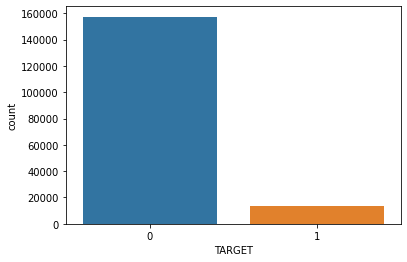

In [ ]:
sns.countplot(x = "TARGET", data = train)
train.loc[:, 'TARGET'].value_counts()

In [ ]:
print(train.info())
print("*******************************")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Columns: 115 entries, SK_ID_CURR to EXT_SOURCE_3_NUM
dtypes: float64(62), int64(35), object(11), uint8(7)
memory usage: 142.2+ MB
None
*******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61500 entries, 0 to 61499
Columns: 114 entries, SK_ID_CURR to EXT_SOURCE_3_NUM
dtypes: float64(62), int64(34), object(11), uint8(7)
memory usage: 50.6+ MB
None


In [ ]:
pd.set_option('display.max_rows', train.shape[0])
train.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,171202.0,85600.500000,49421.904730,0.000000e+00,42800.250000,85600.500000,128400.750000,1.712010e+05
TARGET,171202.0,0.080729,0.272420,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,171202.0,0.416490,0.720138,0.000000e+00,0.000000,0.000000,1.000000,1.400000e+01
AMT_INCOME_TOTAL,171202.0,168371.213673,107234.793540,2.610000e+04,112500.000000,146250.000000,202500.000000,1.350000e+07
AMT_CREDIT,171202.0,599129.309526,402816.996913,4.500000e+04,270000.000000,514602.000000,808650.000000,4.050000e+06
AMT_ANNUITY,171196.0,27127.500701,14538.361801,1.980000e+03,16546.500000,24916.500000,34600.500000,2.580255e+05
AMT_GOODS_PRICE,171039.0,538466.926517,369692.126605,4.500000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,171202.0,0.020839,0.013803,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,171202.0,16045.340504,4363.792228,7.673000e+03,12420.000000,15778.000000,19686.000000,2.522900e+04
DAYS_EMPLOYED,140304.0,2388.583105,2336.564723,1.000000e+00,771.000000,1650.000000,3192.000000,1.791200e+04


In [ ]:
pd.DataFrame(train.isnull().sum().sort_values(ascending = False))

,0
"(False, REGION_POPULATION_RELATIVE)",171202
"(False, OWN_CAR_AGE)",171202
AGE_EMP,132543
EXT_SOURCE_1_NUM,118930
EXT_SOURCE_1,118928
OWN_CAR_AGE,112992
AGE_EMP1,69557
EXT_SOURCE_3_NUM,55016
EXT_SOURCE_3,54586
OCCUPATION_TYPE,53745


In [ ]:
pd.DataFrame(test.isnull().sum().sort_values(ascending = False))

,0
"(False, OWN_CAR_AGE)",61500
"(False, REGION_POPULATION_RELATIVE)",61500
AGE_EMP,47332
EXT_SOURCE_1,42912
EXT_SOURCE_1_NUM,42912
OWN_CAR_AGE,40909
AGE_EMP1,24733
EXT_SOURCE_3_NUM,19867
EXT_SOURCE_3,19690
OCCUPATION_TYPE,18734


# Preprocessing

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px;">

<h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
1. Numerical Field</h3>
</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Missing Data</h3></center>
</div>

In [ ]:
threshold_train = len(train) * 0.60
int(threshold_train)

102721

In [ ]:
threshold_test = len(test) * 0.60
int(threshold_test)

36900

In [ ]:
print("In train data:\n")
print(train.columns[train.isnull().sum() > int(threshold_train)])
print("******************************************")
print("In test data:\n")
print(test.columns[test.isnull().sum() > int(threshold_test)])

In train data:

Index([                        'OWN_CAR_AGE',
                              'EXT_SOURCE_1',
       (False, 'REGION_POPULATION_RELATIVE'),
                      (False, 'OWN_CAR_AGE'),
                                   'AGE_EMP',
                          'EXT_SOURCE_1_NUM'],
      dtype='object')
******************************************
In test data:

Index([                        'OWN_CAR_AGE',
                              'EXT_SOURCE_1',
       (False, 'REGION_POPULATION_RELATIVE'),
                      (False, 'OWN_CAR_AGE'),
                                   'AGE_EMP',
                          'EXT_SOURCE_1_NUM'],
      dtype='object')


In [ ]:
train_new = train#.dropna(axis=1, thresh=threshold_train)
print(train_new.shape)
print("******************************************")
test_new = test#.dropna(axis=1, thresh=threshold_test)
print(test_new.shape)

(171202, 115)
******************************************
(61500, 114)


In [ ]:
numeric_feature = train_new.dtypes!=object
final_numeric_feature = train_new.columns[numeric_feature].tolist()

#----------------------------------------------------
numeric_feature_test = test_new.dtypes!=object
final_numeric_feature_test = test_new.columns[numeric_feature_test].tolist()

In [ ]:
numeric = train_new[final_numeric_feature]

#-------------------------------------------
numeric_test = test_new[final_numeric_feature_test]
numeric.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ROUND_RT_CREDIT_0.0,ROUND_RT_CREDIT_1.0,ROUND_RT_CREDIT_2.0,ROUND_RT_CREDIT_3.0,ROUND_RT_CREDIT_4.0,ROUND_RT_CREDIT_5.0,ROUND_RT_CREDIT_6.0,EXT_SOURCE_1_NUM,EXT_SOURCE_2_NUM,EXT_SOURCE_3_NUM
0,0,0,0.0,112500.0,755190.0,36328.5,675000.0,0.010032,9233.0,878.0,...,0,0,0,0,0,0,1,NaN,0.108401,NaN
1,1,0,0.0,225000.0,585000.0,16893.0,585000.0,0.008019,20148.0,NaN,...,0,0,0,1,0,0,0,NaN,0.053571,0.047919
2,2,0,0.0,54000.0,334152.0,18256.5,270000.0,0.004960,18496.0,523.0,...,0,0,0,0,0,0,1,NaN,0.049430,NaN
3,3,0,0.0,67500.0,152820.0,8901.0,135000.0,0.005002,24177.0,NaN,...,0,0,1,0,0,0,0,NaN,0.200743,0.032609
4,4,1,0.0,157500.0,271066.5,21546.0,234000.0,0.006296,10685.0,697.0,...,0,0,1,0,0,0,0,0.098886,0.112994,0.045455


In [ ]:
discrete_features = numeric.dtypes==int
final_discrete_feature = numeric.columns[discrete_features].tolist()
discrete = numeric[final_discrete_feature]

#-------------------------------------------
discrete_features_test = numeric_test.dtypes==int
final_discrete_feature_test = numeric_test.columns[discrete_features_test].tolist()
discrete_test = numeric_test[final_discrete_feature_test]

discrete.head()

,SK_ID_CURR,TARGET,FLAG_NOT_EMPLOYED,REGION_POPULATION_RELATIVE_0.04622,"(False, REGION_POPULATION_RELATIVE_0.04622)",REGION_POPULATION_RELATIVE_0.072508,"(False, REGION_POPULATION_RELATIVE_0.072508)",OWN_CAR_AGE_64,"(False, OWN_CAR_AGE_64)",OWN_CAR_AGE_65,...,AMT_REQ_CREDIT_BUREAU_MON_NAN,AMT_REQ_CREDIT_BUREAU_QRT_NAN,AMT_REQ_CREDIT_BUREAU_YEAR_NAN,YEARS_EMPLOYED_NAN,FLAG_RT_CREDIT_OVER1,FLAG_UNDER30,FLAG_D30,FLAG_D60,FLAG_O30,FLAG_O60
0,0,0,0,0,1,0,1,0,1,0,...,1,1,1,0,1,1,1,1,0,1
1,1,0,1,0,1,0,1,0,1,0,...,0,0,0,1,1,0,1,1,0,1
2,2,0,0,0,1,0,1,0,1,0,...,1,1,1,0,1,0,1,1,1,1
3,3,0,1,0,1,0,1,0,1,0,...,0,0,0,1,1,0,1,1,0,1
4,4,1,0,0,1,0,1,0,1,0,...,0,0,0,0,1,1,1,1,0,1


In [ ]:
pd.DataFrame(discrete.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
AMT_REQ_CREDIT_BUREAU_QRT_NAN,0
OBS_30_CNT_SOCIAL_CIRCLE_NAN,0
DEF_30_CNT_SOCIAL_CIRCLE_NAN,0
OBS_60_CNT_SOCIAL_CIRCLE_NAN,0
DEF_60_CNT_SOCIAL_CIRCLE_NAN,0
AMT_REQ_CREDIT_BUREAU_HOUR_NAN,0
AMT_REQ_CREDIT_BUREAU_MON_NAN,0
AMT_REQ_CREDIT_BUREAU_YEAR_NAN,0
EXT_SOURCE_2_NAN,0


In [ ]:
pd.DataFrame(discrete_test.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
AMT_REQ_CREDIT_BUREAU_QRT_NAN,0
OBS_30_CNT_SOCIAL_CIRCLE_NAN,0
DEF_30_CNT_SOCIAL_CIRCLE_NAN,0
OBS_60_CNT_SOCIAL_CIRCLE_NAN,0
DEF_60_CNT_SOCIAL_CIRCLE_NAN,0
AMT_REQ_CREDIT_BUREAU_HOUR_NAN,0
AMT_REQ_CREDIT_BUREAU_MON_NAN,0
AMT_REQ_CREDIT_BUREAU_YEAR_NAN,0
FLAG_NOT_EMPLOYED,0


In [ ]:
continuous_features = numeric.dtypes==float
final_continuous_feature = numeric.columns[continuous_features].tolist()
continuous = numeric[final_continuous_feature]

#-------------------------------------------
continuous_features_test = numeric_test.dtypes==float
final_continuous_feature_test = numeric_test.columns[continuous_features_test].tolist()
continuous_test = numeric_test[final_continuous_feature_test]

continuous.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,NUM_NAME_FAMILY_STATUS,NUM_NAME_INCOME_TYPE,NUM_NAME_EDUCATION_TYPE,NUM_NAME_HOUSING_TYPE,NUM_NAME_TYPE_SUITE,NUM_YEARS_BIRTH,NUM_YEARS_LAST_PHONE_CHANGE,EXT_SOURCE_1_NUM,EXT_SOURCE_2_NUM,EXT_SOURCE_3_NUM
0,0.0,112500.0,755190.0,36328.5,675000.0,0.010032,9233.0,878.0,333.0,522.0,...,0.075565,0.095482,0.053692,0.077839,0.081859,0.106890,0.097060,NaN,0.108401,NaN
1,0.0,225000.0,585000.0,16893.0,585000.0,0.008019,20148.0,NaN,4469.0,3436.0,...,0.075565,0.054184,0.089218,0.077839,0.081859,0.058252,0.091687,NaN,0.053571,0.047919
2,0.0,54000.0,334152.0,18256.5,270000.0,0.004960,18496.0,523.0,3640.0,2050.0,...,0.075565,0.058882,0.089218,0.077839,0.074208,0.069032,0.097060,NaN,0.049430,NaN
3,0.0,67500.0,152820.0,8901.0,135000.0,0.005002,24177.0,NaN,4950.0,3951.0,...,0.057529,0.054184,0.110642,0.077839,0.072113,0.031373,0.092564,NaN,0.200743,0.032609
4,0.0,157500.0,271066.5,21546.0,234000.0,0.006296,10685.0,697.0,5101.0,3226.0,...,0.075565,0.075212,0.089218,0.117996,0.081859,0.107514,0.076172,0.098886,0.112994,0.045455


In [ ]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
"(False, OWN_CAR_AGE)",171202
"(False, REGION_POPULATION_RELATIVE)",171202
AGE_EMP,132543
EXT_SOURCE_1_NUM,118930
EXT_SOURCE_1,118928
OWN_CAR_AGE,112992
AGE_EMP1,69557
EXT_SOURCE_3_NUM,55016
EXT_SOURCE_3,54586
DAYS_EMPLOYED,30898


In [ ]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
"(False, OWN_CAR_AGE)",61500
"(False, REGION_POPULATION_RELATIVE)",61500
AGE_EMP,47332
EXT_SOURCE_1,42912
EXT_SOURCE_1_NUM,42912
OWN_CAR_AGE,40909
AGE_EMP1,24733
EXT_SOURCE_3_NUM,19867
EXT_SOURCE_3,19690
DAYS_EMPLOYED,10565


In [ ]:
continuous_col = continuous.columns

In [ ]:
Q1 = train_new.quantile(0.25)
Q3 = train_new.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
#for i in range(len(continuous_col)):
#    preprocess(continuous[continuous_col], continuous_col[i])

In [ ]:
continuous_is_null = continuous.isnull().sum() != 0
final_continuous_feature = continuous.columns[continuous_is_null].tolist()
print("In train: \n",final_continuous_feature)

print("****************************************")
continuous_is_null_test = continuous_test.isnull().sum() != 0
final_continuous_feature_test = continuous_test.columns[continuous_is_null_test].tolist()
print("In test: \n",final_continuous_feature_test)

In train: 
 ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'YEARS_LAST_PHONE_CHANGE', 'YEARS_EMPLOYED', 'MONTH_LAST_PHONE_CHANGE', (False, 'REGION_POPULATION_RELATIVE'), (False, 'OWN_CAR_AGE'), 'RT_GOODS_PRICE', 'AGE_EMP', 'AGE_EMP1', 'RT_ANNUITY', 'NUM_NAME_TYPE_SUITE', 'NUM_YEARS_LAST_PHONE_CHANGE', 'EXT_SOURCE_1_NUM', 'EXT_SOURCE_2_NUM', 'EXT_SOURCE_3_NUM']
****************************************
In test: 
 ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT

In [ ]:
print("In train:\n")
for i in range(len(final_continuous_feature)):
    replace_mean(continuous, final_continuous_feature[i])

print("************************************")
print("In test:\n")
for i in range(len(final_continuous_feature_test)):
    replace_mean(continuous_test, final_continuous_feature_test[i])

In train:

NaN in AMT_ANNUITY raplaced with 27127.500700950957
NaN in AMT_GOODS_PRICE raplaced with 538466.9265167593
NaN in DAYS_EMPLOYED raplaced with 2388.583105257156
NaN in OWN_CAR_AGE raplaced with 12.024428792303727
NaN in CNT_FAM_MEMBERS raplaced with 2.1523306074766353
NaN in EXT_SOURCE_1 raplaced with 0.5016917304189625
NaN in EXT_SOURCE_2 raplaced with 0.5145082557908564
NaN in EXT_SOURCE_3 raplaced with 0.5111771488927158
NaN in OBS_30_CNT_SOCIAL_CIRCLE raplaced with 1.4231373284420012
NaN in DEF_30_CNT_SOCIAL_CIRCLE raplaced with 0.14391533151275773
NaN in OBS_60_CNT_SOCIAL_CIRCLE raplaced with 1.4064063946742302
NaN in DEF_60_CNT_SOCIAL_CIRCLE raplaced with 0.10043834460449358
NaN in DAYS_LAST_PHONE_CHANGE raplaced with 962.411218392416
NaN in AMT_REQ_CREDIT_BUREAU_HOUR raplaced with 0.006651540321164728
NaN in AMT_REQ_CREDIT_BUREAU_MON raplaced with 0.26841835149845356
NaN in AMT_REQ_CREDIT_BUREAU_QRT raplaced with 0.26754723606552944
NaN in AMT_REQ_CREDIT_BUREAU_YEAR ra

In [ ]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
"(False, REGION_POPULATION_RELATIVE)",171202
"(False, OWN_CAR_AGE)",171202
CNT_CHILDREN,0
RT_CREDIT,0
DAYS_LAST_PHONE_CHANGE,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_YEAR,0
YEARS_BIRTH,0


In [ ]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
"(False, REGION_POPULATION_RELATIVE)",61500
"(False, OWN_CAR_AGE)",61500
CNT_CHILDREN,0
RT_CREDIT,0
DAYS_LAST_PHONE_CHANGE,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_YEAR,0
YEARS_BIRTH,0


In [ ]:
numeric[continuous_col] = continuous[continuous_col]

# ----------------------------------------------
numeric_test[continuous_col] = continuous_test[continuous_col]

In [ ]:
continuous_test.columns

Index([                       'CNT_CHILDREN',
                          'AMT_INCOME_TOTAL',
                                'AMT_CREDIT',
                               'AMT_ANNUITY',
                           'AMT_GOODS_PRICE',
                'REGION_POPULATION_RELATIVE',
                                'DAYS_BIRTH',
                             'DAYS_EMPLOYED',
                         'DAYS_REGISTRATION',
                           'DAYS_ID_PUBLISH',
                               'OWN_CAR_AGE',
                                'FLAG_MOBIL',
                            'FLAG_EMP_PHONE',
                           'FLAG_WORK_PHONE',
                          'FLAG_CONT_MOBILE',
                                'FLAG_PHONE',
                                'FLAG_EMAIL',
                           'CNT_FAM_MEMBERS',
                      'REGION_RATING_CLIENT',
               'REGION_RATING_CLIENT_W_CITY',
                'REG_REGION_NOT_LIVE_REGION',
                'REG_REGION_NOT_WO

In [ ]:

train=pd.get_dummies(train,columns=['CODE_GENDER',
                                    'CNT_CHILDREN',
                                    'AMT_GOODS_PRICE',
                                    'NAME_TYPE_SUITE',
                                    'NAME_INCOME_TYPE',
                                    'NAME_EDUCATION_TYPE',
                                    'NAME_FAMILY_STATUS',
                                    'NAME_HOUSING_TYPE',
                                    'REGION_POPULATION_RELATIVE',
                                    'OWN_CAR_AGE',
                                    'OCCUPATION_TYPE',
                                    'CNT_FAM_MEMBERS',
                                    'REGION_RATING_CLIENT',
                                    'REGION_RATING_CLIENT_W_CITY',
                                    'ORGANIZATION_TYPE',
                                    'OBS_30_CNT_SOCIAL_CIRCLE',
                                    'DEF_30_CNT_SOCIAL_CIRCLE',
                                    'OBS_60_CNT_SOCIAL_CIRCLE',
                                    'DEF_60_CNT_SOCIAL_CIRCLE',
                                    'AMT_REQ_CREDIT_BUREAU_HOUR',
                                    'AMT_REQ_CREDIT_BUREAU_MON',
                                    'AMT_REQ_CREDIT_BUREAU_QRT',
                                    'AMT_REQ_CREDIT_BUREAU_YEAR',
                                    'YEARS_BIRTH',
                                    'YEARS_ID_PUBLISH',
                                    'YEARS_REGISTRATION',
                                    'YEARS_LAST_PHONE_CHANGE',
                                    'YEARS_EMPLOYED'])
test=pd.get_dummies(test,columns=['CODE_GENDER',
                                    'CNT_CHILDREN',
                                    'AMT_GOODS_PRICE',
                                    'NAME_TYPE_SUITE',
                                    'NAME_INCOME_TYPE',
                                    'NAME_EDUCATION_TYPE',
                                    'NAME_FAMILY_STATUS',
                                    'NAME_HOUSING_TYPE',
                                    'REGION_POPULATION_RELATIVE',
                                    'OWN_CAR_AGE',
                                    'OCCUPATION_TYPE',
                                    'CNT_FAM_MEMBERS',
                                    'REGION_RATING_CLIENT',
                                    'REGION_RATING_CLIENT_W_CITY',
                                    'ORGANIZATION_TYPE',
                                    'OBS_30_CNT_SOCIAL_CIRCLE',
                                    'DEF_30_CNT_SOCIAL_CIRCLE',
                                    'OBS_60_CNT_SOCIAL_CIRCLE',
                                    'DEF_60_CNT_SOCIAL_CIRCLE',
                                    'AMT_REQ_CREDIT_BUREAU_HOUR',
                                    'AMT_REQ_CREDIT_BUREAU_MON',
                                    'AMT_REQ_CREDIT_BUREAU_QRT',
                                    'AMT_REQ_CREDIT_BUREAU_YEAR',
                                    'YEARS_BIRTH',
                                    'YEARS_ID_PUBLISH',
                                    'YEARS_REGISTRATION',
                                    'YEARS_LAST_PHONE_CHANGE',
                                    'YEARS_EMPLOYED'])

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Outlier</h3></center>
</div>

In [ ]:
col_names = numeric.columns

# ------------------------------------
col_names_test = numeric_test.columns

In [ ]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(outlier_detect(numeric,col_names[i]).shape[0])))
    
print("\n\n***************************************\n")
print("In test:\n")
for i in range(len(col_names_test)):
    print("{}: {}".format(col_names_test[i],(outlier_detect(numeric_test,col_names_test[i]).shape[0])))

In train:

SK_ID_CURR: 0
TARGET: 13821
CNT_CHILDREN: 66
AMT_INCOME_TOTAL: 1665
AMT_CREDIT: 262
AMT_ANNUITY: 581
AMT_GOODS_PRICE: 622
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 2041
DAYS_REGISTRATION: 1
DAYS_ID_PUBLISH: 0
OWN_CAR_AGE: 1840
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 30903
FLAG_WORK_PHONE: 34193
FLAG_CONT_MOBILE: 289
FLAG_PHONE: 0
FLAG_EMAIL: 9773
CNT_FAM_MEMBERS: 61
REGION_RATING_CLIENT: 44800
REGION_RATING_CLIENT_W_CITY: 43420
REG_REGION_NOT_LIVE_REGION: 2603
REG_REGION_NOT_WORK_REGION: 8664
LIVE_REGION_NOT_WORK_REGION: 6979
REG_CITY_NOT_LIVE_CITY: 13422
REG_CITY_NOT_WORK_CITY: 39386
LIVE_CITY_NOT_WORK_CITY: 30672
EXT_SOURCE_1: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 3468
DEF_30_CNT_SOCIAL_CIRCLE: 20186
OBS_60_CNT_SOCIAL_CIRCLE: 3363
DEF_60_CNT_SOCIAL_CIRCLE: 14982
DAYS_LAST_PHONE_CHANGE: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 24049
AMT_REQ_CREDIT_BUREAU_MON: 47469
AMT_REQ_CREDIT_BUREAU_QRT: 51389
AMT_REQ_CREDIT_BUREAU_YEAR: 34
FLAG_NOT_EMPLOYED: 30898
YEA

In [ ]:
outlier = []
for i in range(len(final_numeric_feature)):
    if outlier_detect(numeric[final_numeric_feature],final_numeric_feature[i]).shape[0] !=0:
        outlier.append(final_numeric_feature[i])

outlier_test = []
for i in range(len(final_numeric_feature_test)):
    if outlier_detect(numeric_test[final_numeric_feature_test],final_numeric_feature_test[i]).shape[0] !=0:
        outlier_test.append(final_numeric_feature_test[i])

In [ ]:
# without TARGET field
col_names = outlier_test

In [ ]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 66
AMT_INCOME_TOTAL: 1665
AMT_CREDIT: 262
AMT_ANNUITY: 581
AMT_GOODS_PRICE: 622
DAYS_EMPLOYED: 2041
OWN_CAR_AGE: 1840
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 34193
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 9773
CNT_FAM_MEMBERS: 61
REGION_RATING_CLIENT: 26999
REGION_RATING_CLIENT_W_CITY: 24517
REG_REGION_NOT_LIVE_REGION: 2603
REG_REGION_NOT_WORK_REGION: 8664
LIVE_REGION_NOT_WORK_REGION: 6979
REG_CITY_NOT_LIVE_CITY: 13422
REG_CITY_NOT_WORK_CITY: 39386
LIVE_CITY_NOT_WORK_CITY: 30672
OBS_30_CNT_SOCIAL_CIRCLE: 3468
DEF_30_CNT_SOCIAL_CIRCLE: 20186
OBS_60_CNT_SOCIAL_CIRCLE: 3363
DEF_60_CNT_SOCIAL_CIRCLE: 14982
AMT_REQ_CREDIT_BUREAU_HOUR: 24049
AMT_REQ_CREDIT_BUREAU_MON: 47469
AMT_REQ_CREDIT_BUREAU_QRT: 51389
AMT_REQ_CREDIT_BUREAU_YEAR: 34
FLAG_NOT_EMPLOYED: 30898
YEARS_EMPLOYED: 1504
LOW_DEFAULT_ORG: 252
HIGH_DEFAULT_ORG: 662
AMT_ANNUITY_NAN: 6
AMT_GOODS_PRICE_NAN: 163
DAYS_EMPLOYED_NAN: 30898
EXT_SOURCE_2_NAN: 369
OBS_30_CNT_SOCIAL_CIRCLE_NAN: 560
DEF_30_CNT_SOCIAL_CIRCLE_NAN: 560


In [ ]:
#for i in range(len(col_names)):
#    replace_upper(numeric, col_names[i])   
    
#------------------------------------------------------
#for i in range(len(col_names)):
#    replace_upper(numeric_test, col_names[i])   

In [ ]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 66
AMT_INCOME_TOTAL: 1665
AMT_CREDIT: 262
AMT_ANNUITY: 581
AMT_GOODS_PRICE: 622
DAYS_EMPLOYED: 2041
OWN_CAR_AGE: 1840
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 34193
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 9773
CNT_FAM_MEMBERS: 61
REGION_RATING_CLIENT: 26999
REGION_RATING_CLIENT_W_CITY: 24517
REG_REGION_NOT_LIVE_REGION: 2603
REG_REGION_NOT_WORK_REGION: 8664
LIVE_REGION_NOT_WORK_REGION: 6979
REG_CITY_NOT_LIVE_CITY: 13422
REG_CITY_NOT_WORK_CITY: 39386
LIVE_CITY_NOT_WORK_CITY: 30672
OBS_30_CNT_SOCIAL_CIRCLE: 3468
DEF_30_CNT_SOCIAL_CIRCLE: 20186
OBS_60_CNT_SOCIAL_CIRCLE: 3363
DEF_60_CNT_SOCIAL_CIRCLE: 14982
AMT_REQ_CREDIT_BUREAU_HOUR: 24049
AMT_REQ_CREDIT_BUREAU_MON: 47469
AMT_REQ_CREDIT_BUREAU_QRT: 51389
AMT_REQ_CREDIT_BUREAU_YEAR: 34
FLAG_NOT_EMPLOYED: 30898
YEARS_EMPLOYED: 1504
LOW_DEFAULT_ORG: 252
HIGH_DEFAULT_ORG: 662
AMT_ANNUITY_NAN: 6
AMT_GOODS_PRICE_NAN: 163
DAYS_EMPLOYED_NAN: 30898
EXT_SOURCE_2_NAN: 369
OBS_30_CNT_SOCIAL_CIRCLE_NAN: 560
DEF_30_CNT_SOCIAL_CIRCLE_NAN: 560


In [ ]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
DAYS_EMPLOYED: 0
OWN_CAR_AGE: 0
FLAG_EMP_PHONE: 30903
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 289
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 17801
REGION_RATING_CLIENT_W_CITY: 18903
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0
FLAG_NOT_EMPLOYED: 0
YEARS_EMPLOYED: 0
LOW_DEFAULT_ORG: 0
HIGH_DEFAULT_ORG: 0
AMT_ANNUITY_NAN: 0
AMT_GOODS_PRICE_NAN: 0
DAYS_EMPLOYED_NAN: 0
EXT_SOURCE_2_NAN: 0
OBS_30_CNT_SOCIAL_CIRCLE_NAN: 0
DEF_30_CNT_SOCIAL_CIRCLE_NAN: 0
OBS_60_CNT_SOCIAL_CIRCLE_NAN: 0
DEF_60_CNT_SOCIAL_CIRCLE_NAN: 0
AMT_REQ_CREDIT_BUREAU_HOU

In [ ]:
#for i in range(len(col_names)):
#    replace_lower(numeric, col_names[i])
    
# #--------------------------------------------------
#for i in range(len(col_names)):
 #   replace_lower(numeric_test, col_names[i])

In [ ]:
#print("In train:\n")
#for i in range(len(col_names)):
#    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
#print("\n\n****************************************\n")
#print("In test:\n")
#for i in range(len(col_names)):
#    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px;">

<h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
2. Categorical field</h3>
</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Missing Data</h3></center>
</div>

In [ ]:
categorical_feature = train_new.dtypes==object
final_categorical_feature = train_new.columns[categorical_feature].tolist()

#----------------------------------------------------
categorical_feature_test = test_new.dtypes==object
final_categorical_feature_test = test_new.columns[categorical_feature_test].tolist()

In [ ]:
categorical = train_new[final_categorical_feature]

#---------------------------------------------
categorical_test = test_new[final_categorical_feature_test]
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,Cash loans,F,N,N,Unaccompanied,Working,Higher education,Married,House / apartment,Core staff,School
1,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,XNA
2,Cash loans,F,N,Y,Family,State servant,Secondary / secondary special,Married,House / apartment,Core staff,Postal
3,Cash loans,F,N,Y,Children,Pensioner,Lower secondary,Widow,House / apartment,NaN,XNA
4,Cash loans,M,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,Drivers,Business Entity Type 3


In [ ]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,53745
FLAG_OWN_CAR,34241
FLAG_OWN_REALTY,34241
NAME_TYPE_SUITE,747
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [ ]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,18734
FLAG_OWN_CAR,12334
FLAG_OWN_REALTY,12334
NAME_TYPE_SUITE,248
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [ ]:
col_names_cat = categorical.columns

******************** NAME_CONTRACT_TYPE ********************



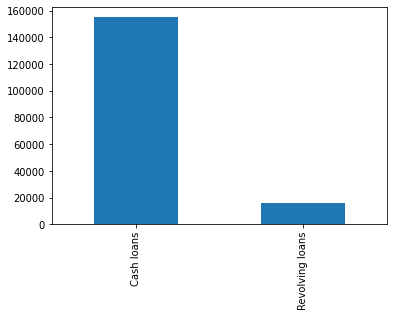

******************** CODE_GENDER ********************



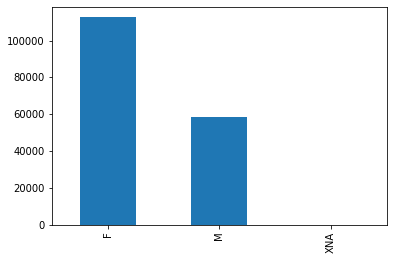

******************** FLAG_OWN_CAR ********************



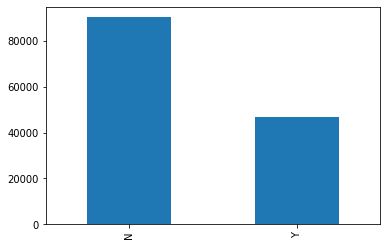

******************** FLAG_OWN_REALTY ********************



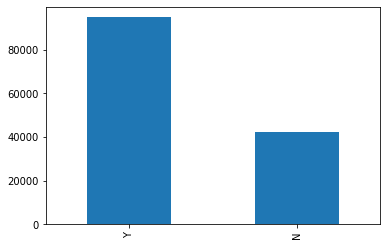

******************** NAME_TYPE_SUITE ********************



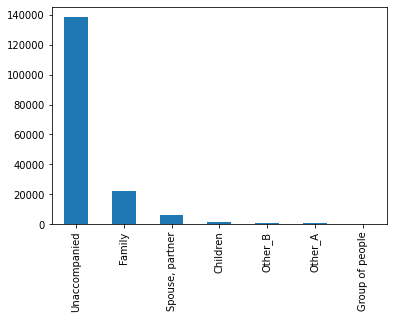

******************** NAME_INCOME_TYPE ********************



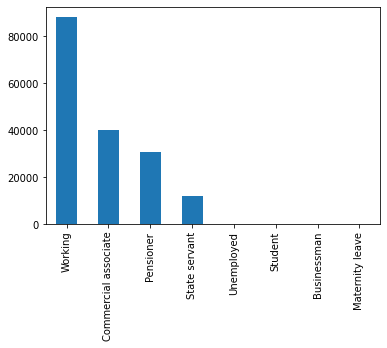

******************** NAME_EDUCATION_TYPE ********************



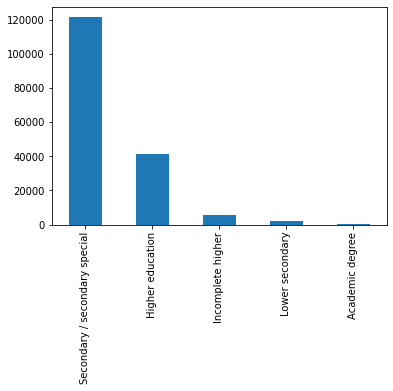

******************** NAME_FAMILY_STATUS ********************



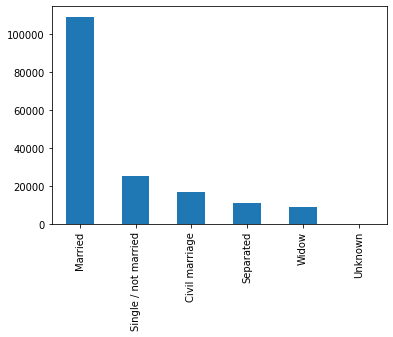

******************** NAME_HOUSING_TYPE ********************



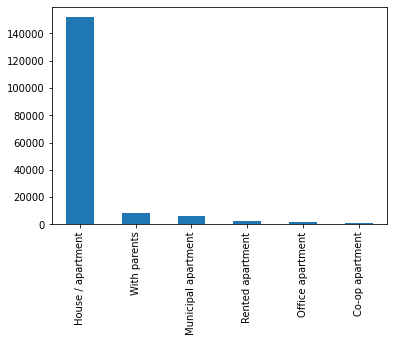

******************** OCCUPATION_TYPE ********************



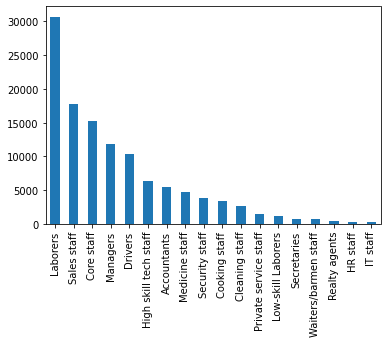

******************** ORGANIZATION_TYPE ********************



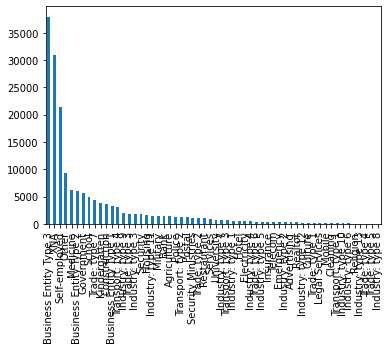

In [ ]:
for i in range(len(col_names_cat)):
    preprocess_cat(categorical, col_names_cat[i])

In [ ]:
print("unique number is = {}\nunique values are: \n{} ".format(len(train_new['ORGANIZATION_TYPE'].unique()), train_new['ORGANIZATION_TYPE'].unique()))

unique number is = 58
unique values are: 
['School' 'XNA' 'Postal' 'Business Entity Type 3' 'Transport: type 4'
 'Trade: type 3' 'Military' 'Self-employed' 'Bank'
 'Business Entity Type 2' 'Kindergarten' 'Trade: type 7' 'Hotel'
 'Services' 'Other' 'Medicine' 'Government' 'Construction' 'Agriculture'
 'University' 'Religion' 'Industry: type 4' 'Advertising' 'Legal Services'
 'Business Entity Type 1' 'Industry: type 9' 'Industry: type 11'
 'Industry: type 3' 'Trade: type 6' 'Industry: type 10' 'Trade: type 1'
 'Housing' 'Industry: type 1' 'Security Ministries' 'Industry: type 12'
 'Security' 'Industry: type 7' 'Transport: type 3' 'Transport: type 2'
 'Police' 'Realtor' 'Restaurant' 'Culture' 'Insurance' 'Emergency'
 'Mobile' 'Electricity' 'Telecom' 'Trade: type 2' 'Industry: type 13'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 5'
 'Industry: type 6' 'Cleaning' 'Trade: type 4' 'Industry: type 8'
 'Trade: type 5'] 


In [ ]:
print("In train:\n")
#for i in range(len(col_names_cat)):
 #   replace_mode(categorical, col_names_cat[i])

print("\n\n****************************************\n")
print("In test:\n")
#for i in range(len(col_names_cat)):
 #   replace_mode(categorical_test, col_names_cat[i])

In train:



****************************************

In test:



In [ ]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,53745
FLAG_OWN_CAR,34241
FLAG_OWN_REALTY,34241
NAME_TYPE_SUITE,747
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [ ]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,18734
FLAG_OWN_CAR,12334
FLAG_OWN_REALTY,12334
NAME_TYPE_SUITE,248
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [ ]:
categorical.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
# ---------------------------------------------
categorical_test.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

In [ ]:
le = LabelEncoder() 
categorical = categorical.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical_test = categorical_test.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,0,0,0,0,6,7,1,1,1,3
1,0,0,0,1,6,3,4,1,1,18
2,0,0,0,1,1,4,4,1,1,3
3,0,0,0,1,0,3,3,5,1,18
4,0,1,0,0,6,1,4,1,5,4


In [ ]:
print("In train: ",categorical.shape)
print("In test: ",categorical_test.shape)

In train:  (171202, 10)
In test:  (61500, 10)


In [ ]:
col_names_cat = categorical.columns

In [ ]:
train_new[col_names_cat] = categorical[col_names_cat]
train_new[col_names] = numeric[col_names]

# ----------------------------------------------------
test_new[col_names] = numeric_test[col_names]
test_new[col_names_cat] = categorical_test[col_names_cat]

In [ ]:
#train_new = pd.get_dummies(train_new, columns=['ORGANIZATION_TYPE'])
#test_new = pd.get_dummies(test_new, columns =['ORGANIZATION_TYPE'])

In [ ]:
train_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
test_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Duplicate Data</h3></center>
</div>

In [ ]:
print("In train: ",train_new.loc[train.duplicated()].shape)
#--------------------------------------------------
print("In test: ",test_new.loc[test.duplicated()].shape)

In train:  (0, 114)
In test:  (0, 113)


# Normalization

In [ ]:
x_train = train_new.drop("TARGET", axis = 1)
y = train_new['TARGET']

In [ ]:
test_new.columns

Index([         'SK_ID_CURR',  'NAME_CONTRACT_TYPE',         'CODE_GENDER',
              'FLAG_OWN_CAR',     'FLAG_OWN_REALTY',        'CNT_CHILDREN',
          'AMT_INCOME_TOTAL',          'AMT_CREDIT',         'AMT_ANNUITY',
           'AMT_GOODS_PRICE',
       ...
       'ROUND_RT_CREDIT_0.0', 'ROUND_RT_CREDIT_1.0', 'ROUND_RT_CREDIT_2.0',
       'ROUND_RT_CREDIT_3.0', 'ROUND_RT_CREDIT_4.0', 'ROUND_RT_CREDIT_5.0',
       'ROUND_RT_CREDIT_6.0',    'EXT_SOURCE_1_NUM',    'EXT_SOURCE_2_NUM',
          'EXT_SOURCE_3_NUM'],
      dtype='object', length=113)

In [ ]:
x_train.columns

Index([         'SK_ID_CURR',  'NAME_CONTRACT_TYPE',         'CODE_GENDER',
              'FLAG_OWN_CAR',     'FLAG_OWN_REALTY',        'CNT_CHILDREN',
          'AMT_INCOME_TOTAL',          'AMT_CREDIT',         'AMT_ANNUITY',
           'AMT_GOODS_PRICE',
       ...
       'ROUND_RT_CREDIT_0.0', 'ROUND_RT_CREDIT_1.0', 'ROUND_RT_CREDIT_2.0',
       'ROUND_RT_CREDIT_3.0', 'ROUND_RT_CREDIT_4.0', 'ROUND_RT_CREDIT_5.0',
       'ROUND_RT_CREDIT_6.0',    'EXT_SOURCE_1_NUM',    'EXT_SOURCE_2_NUM',
          'EXT_SOURCE_3_NUM'],
      dtype='object', length=113)

In [ ]:
scaler=MinMaxScaler()
col = ['NAME_CONTRACT_TYPE',
       'CODE_GENDER', 
       'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 
       'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 
       'NAME_TYPE_SUITE', 
       'NAME_INCOME_TYPE',
       'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH',
       'DAYS_EMPLOYED',
       'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 
       'OCCUPATION_TYPE', 
       'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY',
       'EXT_SOURCE_2',
       'EXT_SOURCE_3',
       'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 
       'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 
       'AMT_REQ_CREDIT_BUREAU_YEAR',
       'RT_CREDIT',
       'RT_GOODS_PRICE',
       'RT_ANNUITY', 
       'YEARS_BIRTH', 
       'YEARS_EMPLOYED',
       'YEARS_REGISTRATION', 
       'YEARS_ID_PUBLISH',
       'YEARS_LAST_PHONE_CHANGE',
       'MONTH_LAST_PHONE_CHANGE',
       'NUM_ORGANIZATION_TYPE',
       'NUM_NAME_FAMILY_STATUS',
       'NUM_NAME_INCOME_TYPE',
       'NUM_NAME_EDUCATION_TYPE',
       'NUM_NAME_HOUSING_TYPE',
       'NUM_NAME_TYPE_SUITE',
       'NUM_YEARS_BIRTH',
       'NUM_YEARS_LAST_PHONE_CHANGE',
       'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 
       'AMT_CREDIT',
       'OWN_CAR_AGE', 'EXT_SOURCE_1',
       'AGE_EMP',
       'AGE_EMP1'
       ]

x_train[col] = pd.DataFrame(scaler.fit_transform(x_train[col]))
test_new[col] = pd.DataFrame(scaler.transform(test_new[col]))

# Modeling with tuned hyperparameters

<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#fef1ff;padding: 25px 10px">
We used Random search for tuning hyperparameters</div>

In [ ]:
# Value of hyperparameters for random search

param_lgb = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
             'num_leaves':range(10,100,10),
              'min_child_samples':range(500,1000,100),
              'reg_alpha':[0.1,0.01,0.2,0.3],
              'reg_lambda':[0.1,0.01,0.2,0.3],
             'n_estimators':range(50,300,50),
              'max_bin': range(500,1500,100)}

#RndSrch_Tune(LGBMClassifier(random_state = 100, n_jobs=-1, class_weight = 'balanced'), 
#              x_train, y, param_lgb)

In [ ]:
lgb = LGBMClassifier(**{'reg_lambda': 0.1, 
                        'reg_alpha': 0.1, 
                        'num_leaves': 10, 
                        'n_estimators': 250, 
                        'min_child_samples': 600, 
                        'learning_rate': 0.05,
                        'max_bin': 500,
                        'objective': 'binary',
                        'n_jobs': -1,
                        'class_weight':'balanced',
                        'random_state':100})

x_train.drop(['SK_ID_CURR'], axis=1, inplace=True)
test_new.drop(['SK_ID_CURR'], axis=1, inplace=True)
scores = cross_validation(x_train, y, lgb)
print(scores)

Score: 0.758064
None


best score is : 0.7439544639382981
best estimator is : LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_bin=500,
               min_child_samples=600, n_estimators=250, num_leaves=10,
               random_state=100, reg_alpha=0.1, reg_lambda=0.1)
best Params is : {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 10, 'n_estimators': 250, 'min_child_samples': 600, 'max_bin': 500, 'learning_rate': 0.05}
0.7439544639382981

FLAG_D30　更新できました。
FLAG_D60　を加えても全く同じ。
FLAG_O30　更新。
FLAG_O60で成績落ちる。
EXT_SOURCE_2　を落としたら成績が落ちました。
AMTの２項目追加で0.7515669
DAYSの変換で0.751722

DAYS_Phoneで0.75157

AMT/100000で0.751566　落ちた！

FLAG_NOT_EMPLOYED 0.752110

FLAG_FAM_MEM_EQ_2  で0.752102　落ちた！

'NUM_ORGANIZATION_TYPE' 0.752536

NUM_NAMEの大量登録で　0.752446 落ちた！

Num_name_type_suiteを外してみると　0.752446　落ちたまま

さらに

'NUM_NAME_HOUSING_TYPE'を外してみると　0.752446　落ちたまま

さらに

'NUM_OCCUPATION_TYPE'を外してみると　0.752690

'NUM_NAME_HOUSING_TYPE'を戻してみると　0.752690

'NUM_NAME_TYPE_SUITE'を戻してみると　0.752690

'FLAG_OWN_REALTY_NAN'を加えてみても　0.752690

'DEF_30_CNT_SOCIAL_CIRCLE'を戻してみたら　0.752690

'DEF_60_CNT_SOCIAL_CIRCLE'を戻してみたら　 0.752690

'OBS_30_CNT_SOCIAL_CIRCLE'を戻してみたら　0.752549　落ちた　外す

'OBS_60_CNT_SOCIAL_CIRCLE'を外してみると 0.752432 落ちた　もどす 0.752690

'FLAG_O60'をnaのみで入れてみると　0.752690 0を加えると 0.752555 もどす　0.752690

'FLAG_D60'から0を外すと 0.752690

'FLAG_D30'から0を外すと  0.752690

'FLAG_O30'から1を外すと 0.752565 もどす　0.752690

'AMT_REQ_CREDIT_BUREAU_HOUR_NAN'加えてみる　0.752690

'AMT_REQ_CREDIT_BUREAU_YEAR_NAN'加えてみる　0.752690

'AMT_REQ_CREDIT_BUREAU_MON_NAN'加えてみる　0.752690

'AMT_REQ_CREDIT_BUREAU_QRT_NAN',加えてみる 0.752690

AMT_CREDITがスケーリングから外れていたので加えてみる  0.752690

'RT_GOODS_PRICE_INCOME'を加えてみる　0.752582 もどす0.752690

'RT_ANNUITY_INCOME'を加えてみる　0.752523 もどす0.752690

'FLAG_OVER60'を加えてみる0.752690もどす0.752690

'FLAG_OVER50'を加えてみる0.752690もどす0.752690

FLAG_UNDER30を加えてみる0.752690

'NUM_CNT_FAM_MEMBERS'を加えてみる0.752640もどす0.752690

'FLAG_RT_CREDIT_OVER1'を加えてみる0.752690

'AMT_INCOME_TOTAL_LOG'を加えてみる0.752603もどす0.752690

'AMT_CREDIT_LOG'を加えてみる0.752620もどす0.752690

'AMT_GOODS_PRICE_LOG'を加えてみる0.752652もどす0.752690

'AMT_ANNUITY_LOG'を加えてみる0.752611もどす0.752690

'OWN_CAR_AGE', 'EXT_SOURCE_1'を削除しないと0.756976

'OWN_CAR_AGE_NAN'を加えてみる0.757047

'EXT_SOURCE_1_NAN'を加えてみる0.757047

'NUM_YEARS_BIRTH'を加えてみる0.757209

'NUM_YEARS_LAST_PHONE_CHANGE'を加えてみる0.757271

'NUM_YEARS_EMPLOYED'をくわえてみる0.756964　落ちた！戻す。0.757271

'NUM_YEARS_REGISTRATION'をくわえてみる0.756926　落ちた！戻す。0.757271

'NUM_YEARS_ID_PUBLISH'をくわえてみる0.756964　落ちた！戻す。0.757271

'NUM_REALTY_INCOME_CREDIT'を加えてみる0.757244惜しい！'FLAG_OWN_REALTY'外してみる？0.757219間違った戻して'FLAG_OWN_REALTY_NON'外してみる0.757244やっぱりだめ。

REALTY_INCOME_CREDITにしてみる。0.756972さらに駄目。元に戻し

ORGANIZATION_TYPEのドロップをやめる。0.757111良くない。元に戻し。0.757271

ORGANIZATION_TYPEをワンホットエンコーディングに。0.757126 やや良くない。戻す。0.757271

OCCUPATION_TYPEをワンホットエンコーディングに。0.756915　やや良くない。戻す。

NAME_INCOME_TYPEをワンホットエンコーディングに。0.757169 やや良くない。戻す。0.757271

NAME_FAMILY_STATUSをワンホットエンコーディングに。0.756948 悪くなった。戻す。0.757271

NAME_EDUCATION_TYPEをワンホットエンコーディングに。0.757281 良くなった。

収入のカテゴリー化　ワンホットエンコーディングでリベンジ　 0.757142 悪くなった。

借入収入倍率のカテゴリー化　0.757281

OWN_CAR_AGEの不自然な64と65をフラグ化　0.757281

test['REGION_RATING_CLIENT']=test['REGION_RATING_CLIENT'].astype(str) 0.757149 悪くなった！intとしたら　0.757281

'REGION_POPULATION_RELATIVE'の２つの特異値をフラグ化した。0.757281

'EXT_SOURCE_1_NUM'～'EXT_SOURCE_3_NUM'を追加 0.757379

EXT3次元化　n=20 0.757283 下がった！　n=10 0.757191 2次元2枚　0.757379 やはり１次元の方が上。

デフォルト値が異常値の職種のフラグ　0.757379 変わらず

Age30FLAG修正、AGE-EMP導入 0.756762 下がった！

上昇局面と下降局面を別カラムに　0.756846 やや上がったが最高よりは低い。

AGE_EMPとAGE_EMP1はスケーリングを忘れていた。 0.756846　変わらない。

非雇用の雇用年数を０に替えていたのをNANに戻す。0.757504　最高を更新

なんでか　0.757052やや落ちてしまったよ。EMPLOYEDにバグがあった。

綺麗に整理後　0.756971

ID除いて　0.757289

300以上のINCOMEをフラグ化　0.757289

様々な項目のワンホットエンコーディング化

はずれ値のパラメータを1.5から３に変更　757434

外れ値およびmeanのreplaceを無効化　0.757890　最高を更新

全項目ワンホットエンコーディング化　0.758064 最高を更新

# Submission

In [ ]:
lgb.fit(x_train, y)
y_pred_LGB = lgb.predict(x_train)
#test_new.drop(['SK_ID_CURR'], axis=1, inplace=True)
y_pred_LGB_test = lgb.predict(test_new)

In [385]:
output = pd.DataFrame({'SK_ID_CURR': test.SK_ID_CURR, 
                       'TARGET': lgb.predict_proba(test_new)[:,1]})
output.head()

,SK_ID_CURR,TARGET
0,171202,0.284306
1,171203,0.712749
2,171204,0.722840
3,171205,0.578372
4,171206,0.695321


In [386]:
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")
from google.colab import files
files.download('my_submission.csv')

Your submission was successfully saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#fef1ff;padding: 25px 10px">
To be continued... 🚧</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h4 style="padding: 5px 0px; color:#442efb; font-weight: bold; font-family: Cursive">
    Thanks for your attention and for reviewing my notebook.🙌 <br><br>Please write your comments for me.📝</h4></center>
<center><h4 style="padding: 5px 0px; color:#442efb; font-weight: bold; font-family: Cursive">
If you liked my work and found it useful, please upvote. Thank you🙏</h4></center>
</div>

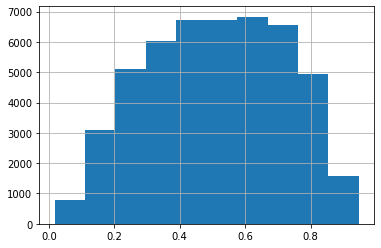

In [ ]:
train.loc[train['TARGET']==0,'EXT_SOURCE_1'].hist(bins=10)

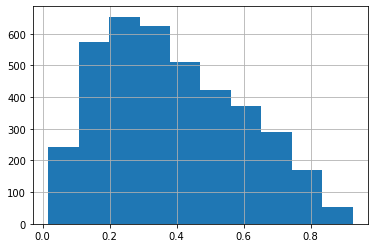

In [ ]:
train.loc[train['TARGET']==1,'EXT_SOURCE_1'].hist(bins=10)

'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 

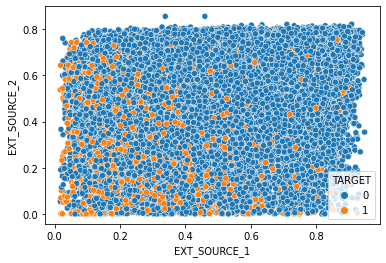

In [ ]:

sns.scatterplot(x="EXT_SOURCE_1", y="EXT_SOURCE_2", hue="TARGET", data=train)

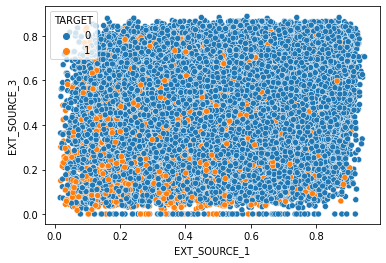

In [ ]:

sns.scatterplot(x="EXT_SOURCE_1", y="EXT_SOURCE_3", hue="TARGET", data=train)

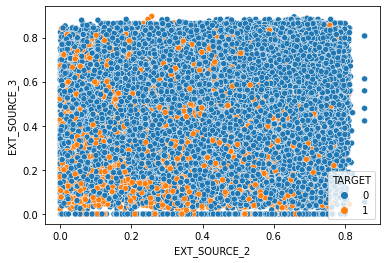

In [ ]:

sns.scatterplot(x="EXT_SOURCE_2", y="EXT_SOURCE_3", hue="TARGET", data=train)